# Conv4 3D Residual v2

### Here we visualize performance of the network on validation set for different signal classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os, re, gc
import h5py
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from cnn_utils import *

Using TensorFlow backend.


In [2]:
from keras.models import  load_model
import tensorflow as tf
import keras.backend as K

# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
load_s = [('C30keV1'),('C30keV2'),('C60keV1'),('C60keV2'),('C100keV1'),('C100keV2')]
class_names = ['C30keV','C60keV','C100keV']
dset = '/home/scanner-ml/Artem/Python/NEWS/data/dataset_clean.h5'

In [4]:
conv_model, preds, X, y, shuffs = {},{},{},{},{}
for s in load_s:
    conv_model[s] = load_model('networks/res_v2/e100/conv4_3d_res_'+s[:-1]+'_'+s[-1]+'.h5', custom_objects={'swish':swish})
for n in class_names:
    print('\t'+n+' vs gamma')
    X[n], y[n], shuffs[n] = load_data_v2(classes={'s_'+n:'full','b_gamma':'full'}, tr_val_test=[False,True,False],
                                         im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=2)
    for s in load_s:
        preds[n+'_'+s] = conv_model[s].predict(X[n]['/images/val'], batch_size=100, verbose=0)
        np.savetxt('outputs/conv4_3d_res/v2/preds/'+n+'_'+s+'.txt',preds[n+'_'+s])
'saving predictions for validation sets'

	C30keV vs gamma
Number of images val samples:  21884
	C60keV vs gamma
Number of images val samples:  21538
	C100keV vs gamma
Number of images val samples:  21825


'saving predictions for validation sets'

dict_keys(['class', 'bckg_rejection', 'efficiency'])


/home/scanner-ml/anaconda3/envs/ML/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


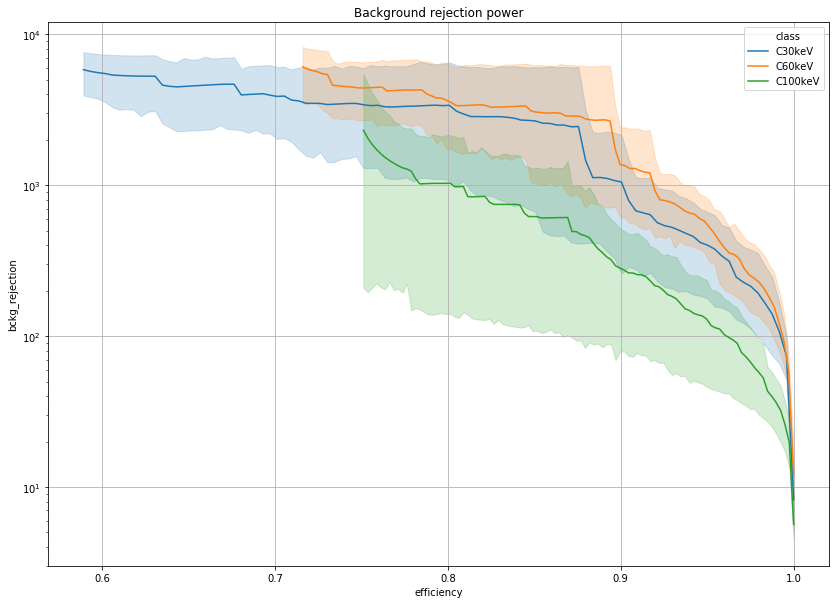

In [5]:
pr_curves, min_eff, interp = {},{},{}
for n in class_names:
    min_eff[n] = 0.1
    for s in load_s:
        prec, rec, thresh = precision_recall_curve(y[n]['/images/val'], preds[n+'_'+s])
        if rec[-2]>min_eff[n]: min_eff[n] = rec[-2] # avoiding extrapolation
        mask = np.ones(len(rec),dtype=bool); mask[-1]=False
        for i,pr in enumerate(prec[:-1]):
            if not pr or pr==1: mask[i] = False
        rec = rec[mask]; prec = prec[mask]
        interp[n+'_'+s] = sp.interpolate.interp1d(rec, prec, fill_value='extrapolate')
        _ = gc.collect()
pr_curves['class'], pr_curves['bckg_rejection'], pr_curves['efficiency'] = [],[],[]
for n in class_names:
    eff = list(np.linspace(min_eff[n],1.0, num=100))
    for s in load_s:
        pr_curves['class'] += [n]*len(eff)
        pr_curves['efficiency'] += eff
        pr_curves['bckg_rejection'] += list((1-interp[n+'_'+s](eff)+1e-6)**-1)
print(pr_curves.keys())
pr_curves = pd.DataFrame(data=pr_curves)

plt.figure(figsize=(14,10))
sns.lineplot(x='efficiency',y='bckg_rejection',hue='class', data=pr_curves)
plt.grid()
plt.yscale('log')
_ = plt.title('Background rejection power')

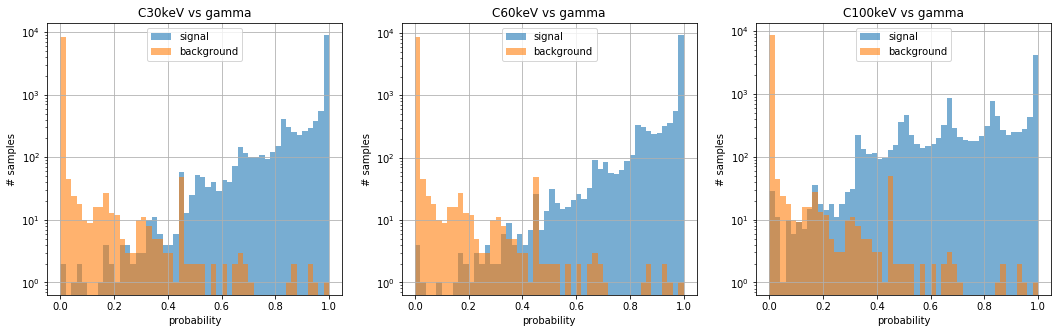

In [6]:
pred_mean, pos, neg = {},{},{}
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, n in enumerate(class_names):
    pred_mean[n] = np.hstack(tuple([preds[n+'_'+s] for s in load_s])).mean(axis=-1)
    pos[n], neg[n] = pos_neg(y[n]['/images/val'], pred_mean[n])
    axes[i].hist(pos[n][:,0], bins=50, label='signal', alpha=0.6, range=(0,1))
    axes[i].hist(neg[n][:,0], bins=50, label='background', alpha=0.6, range=(0,1))
    axes[i].grid()
    axes[i].set_title(n+' vs gamma')
    axes[i].set_yscale('log')
    axes[i].set_ylabel('# samples')
    axes[i].set_xlabel('probability')
    axes[i].legend()